In [39]:
from pathlib import Path
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
input_path = Path.home() / "data/cetesb/raw_html"

In [4]:
filepaths = pd.Series([input_path / file for file in os.listdir(input_path)])
filepaths = filepaths

In [5]:
len(filepaths)

139812

In [ ]:
def parse_pollution_data(raw_html, estacao_id, date):
    html_tables = pd.read_html(raw_html)
    html_tables = html_tables[6:-1]
    dataset = {}
    time = [date + pd.Timedelta(hours=h) for h in range(0, 24)]
    dataset["time"] = time
    dataset["id"] = [estacao_id] * 24
    for html_table in html_tables:
        pollutant = html_table[0][0].split(" ")[0]
        dataset[pollutant] = pd.to_numeric(html_table[0][2:].values, errors='coerce')
    return pd.DataFrame(dataset)

In [ ]:
raw_data = []
for i, filepath in enumerate(filepaths):
    print("\r{}/{}   ".format(i, len(filepaths)), end='')
    splitted_filepath = str(filepath).split("/")[-1].split("_")
    estacao_id = int(splitted_filepath[0])
    datetime = pd.to_datetime(splitted_filepath[-1].split(".")[0])
    with open(filepath, 'r') as fid:
        raw_html = fid.read()
        try:
            iter_data = parse_pollution_data(raw_html, estacao_id, datetime)
            raw_data.append(iter_data)
        except:
            continue

In [ ]:
data = pd.concat(raw_data, sort=False).set_index(["time", "id"])

In [ ]:
#data.to_pickle("cetesb.pkl")

In [6]:
data = pd.read_pickle("cetesb.pkl")

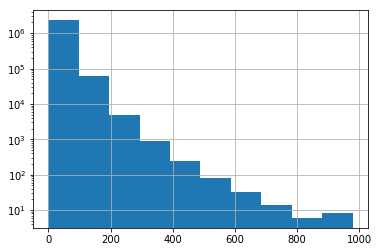

In [7]:
data.MP10.dropna().hist(log=True)
plt.show()

In [8]:
vdata = data.MP10.dropna().reset_index()

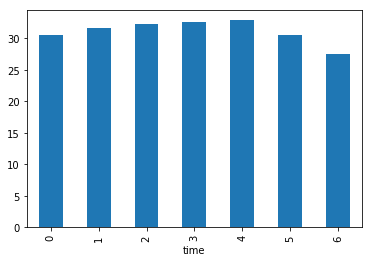

In [9]:
vdata.groupby(vdata.time.dt.dayofweek).MP10.mean().plot(kind='bar')

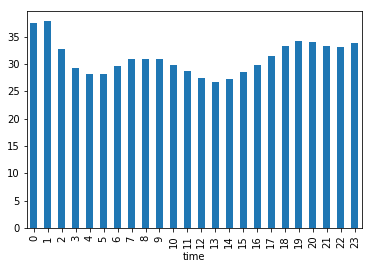

In [10]:
vdata.groupby(vdata.time.dt.hour).MP10.mean().plot(kind='bar')

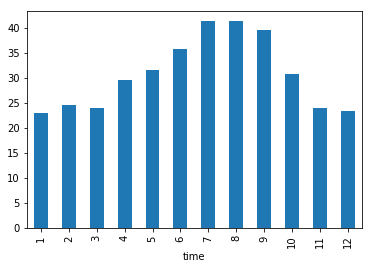

In [11]:
vdata.groupby(vdata.time.dt.month).MP10.mean().plot(kind='bar')

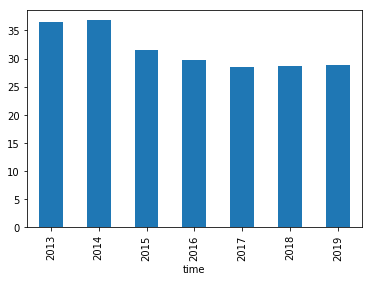

In [12]:
vdata.groupby(vdata.time.dt.year).MP10.mean().plot(kind='bar')

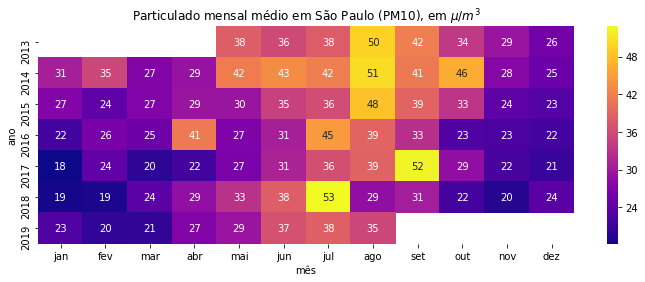

In [104]:
x = vdata.groupby([vdata.time.dt.year, vdata.time.dt.month]).MP10.mean().unstack()
months = ["jan", "fev", "mar", "abr", "mai", "jun", "jul", "ago", "set", "out", "nov", "dez"]

plt.figure(figsize=(12, 4))
sns.heatmap(x, annot=True, xticklabels=months, cmap='plasma')
plt.title("Particulado mensal médio em São Paulo (PM10), em $\mu/m^3$")
plt.xlabel("mês")
plt.ylabel("ano")
plt.show()

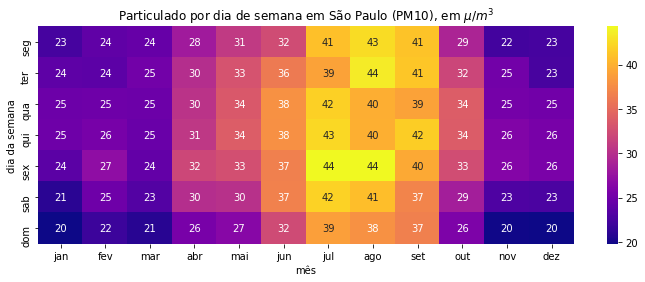

In [102]:
x = vdata.groupby([vdata.time.dt.dayofweek, vdata.time.dt.month]).MP10.mean().unstack()
months = ["jan", "fev", "mar", "abr", "mai", "jun", "jul", "ago", "set", "out", "nov", "dez"]
dayofweeks = ['seg', 'ter', 'qua', 'qui', 'sex', 'sab', 'dom']
plt.figure(figsize=(12, 4))
sns.heatmap(x, annot=True, xticklabels=months, yticklabels=dayofweeks, cmap='plasma')
plt.title("Particulado por dia de semana em São Paulo (PM10), em $\mu/m^3$")
plt.xlabel("mês")
plt.ylabel("dia da semana")
plt.show()

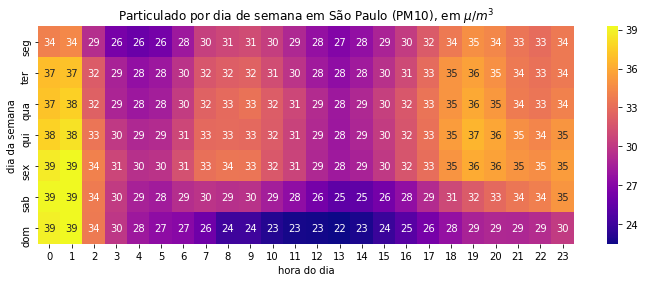

In [105]:
x = vdata.groupby([vdata.time.dt.dayofweek, vdata.time.dt.hour]).MP10.mean().unstack()
#months = ["jan", "fev", "mar", "abr", "mai", "jun", "jul", "ago", "set", "out", "nov", "dez"]
dayofweeks = ['seg', 'ter', 'qua', 'qui', 'sex', 'sab', 'dom']
plt.figure(figsize=(12, 4))
sns.heatmap(x, annot=True, yticklabels=dayofweeks, cmap='plasma')
plt.title("Particulado por dia de semana em São Paulo (PM10), em $\mu/m^3$")
plt.xlabel("hora do dia")
plt.ylabel("dia da semana")
plt.show()

In [109]:
data.columns

Index(['MP10', 'TRS', 'O3', 'NO2', 'CO', 'MP2.5', 'SO2', 'BENZENO', 'TOLUENO'], dtype='object')

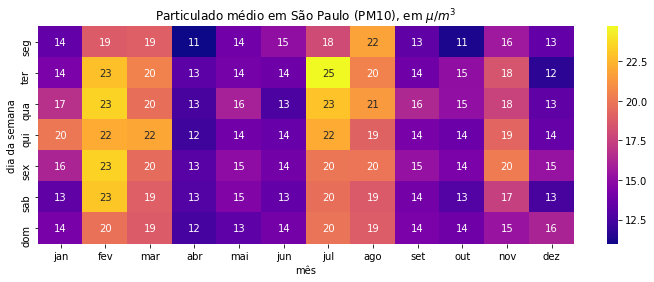

In [112]:
x = data.loc[:, 'MP2.5'].dropna().reset_index().groupby([vdata.time.dt.dayofweek, vdata.time.dt.month])['MP2.5'].mean().unstack()
months = ["jan", "fev", "mar", "abr", "mai", "jun", "jul", "ago", "set", "out", "nov", "dez"]
dayofweeks = ['seg', 'ter', 'qua', 'qui', 'sex', 'sab', 'dom']
plt.figure(figsize=(12, 4))
sns.heatmap(x, annot=True, yticklabels=dayofweeks, xticklabels=months, cmap='plasma')
plt.title("Particulado médio em São Paulo (PM10), em $\mu/m^3$")
plt.xlabel("mês")
plt.ylabel("dia da semana")
plt.show()

In [98]:
data.reset_index().to_feather("cetesb.feather")

In [99]:
data.reset_index().to_csv("cetesb.csv.gzip", compression='gzip')